In [13]:
#import the necessary fucntion 
from parameters_cov_AI import example_population_frame,example_population,parameter_csv
import numpy as np

In [15]:
#------------------------------------------------------------
# disease params
model_params = parameter_csv[parameter_csv['Type']=='Model Parameter']
model_params = model_params.loc[:,['Name','Value']]
# print()
n_Rs = 20
# Controlled transmission 
R0_low = np.random.uniform(1.5,2,n_Rs)
# Moderate transmission
R0_mid = np.random.uniform(2,3,n_Rs)
# Inflated transmission (inflated by the diphtheria inflation factor)
R0_high = np.random.uniform(2*1.65,3*1.65,n_Rs)

# R_0                 = np.float(model_params[model_params['Name']=='R0'].Value)
become_infectious_rate     = 1/(np.float(model_params[model_params['Name']=='infectious_period'].Value))
no_longer_infectious_rate = 1/(np.float(model_params[model_params['Name']=='non_infectious_period'].Value))
hosp_rate           = 1/(np.float(model_params[model_params['Name']=='hosp_period'].Value))
death_rate          = 1/(np.float(model_params[model_params['Name']=='death_period'].Value))

# beta                = R_0*no_longer_infectious_rate # R_0 mu/N, N=1
# infection_matrix    = beta*np.ones((example_population_frame.shape[0],example_population_frame.shape[0]))
death_prob          = np.float(model_params[model_params['Name']=='death_prob'].Value)
number_compartments = int(model_params[model_params['Name']=='number_compartments'].Value)


# Parameters that may come into play later:
# ICU_capacity = 8/100000
# death prob and period given ICU care:
# import_rate = 1/(30*population) # 1 per month

In [18]:
class Parameters:
    def __init__(self,R_0):
        
        self.R_0 = R_0
        self.no_longer_infectious_rate = no_longer_infectious_rate
        self.beta = R_0*no_longer_infectious_rate # R_0 mu/N, N=1
        self.infection_matrix = self.beta*np.ones((example_population_frame.shape[0],example_population_frame.shape[0]))


        self.number_compartments = number_compartments

        self.become_infectious_rate  = become_infectious_rate
        self.hosp_rate = hosp_rate        
        self.death_rate = death_rate
        self.death_prob     = death_prob

        self.S_ind = 0
        self.E_ind = 1
        self.I_ind = 2
        self.R_ind = 3
        self.H_ind = 4
        self.C_ind = 5
        self.D_ind = 6


In [19]:
#generate parameter lists for each category of R0
params_low=[]
for R0 in R0_low:
    params_low.append(Parameters(R0))
params_mid=[]
for R0 in R0_mid:
    params_mid.append(Parameters(R0))
params_high=[]
for R0 in R0_high:
    params_high.append(Parameters(R0))

In [27]:
from math import exp, ceil, log, floor, sqrt
import numpy as np
from scipy.integrate import ode
from scipy.stats import norm, gamma
import pandas as pd
##
# -----------------------------------------------------------------------------------
##
class Simulator:
    def __init__(self,params):
        self.params=params
    ##
#-----------------------------------------------------------------
        
    ##
    def ode_system(self,t,y,population_frame,control_time,beta_factor):
        ##
        dydt = np.zeros(y.shape)

        I_vec = [ y[self.params.I_ind+i*self.params.number_compartments] for i in range(population_frame.shape[0])] # age_categories

        if t > control_time[0] and t < control_time[1]: # control in place
            control_factor = beta_factor
        else:
            control_factor = 1
            


        for i in range(population_frame.shape[0]): # age_categories
            # S
            dydt[self.params.S_ind + i*self.params.number_compartments] = - y[self.params.S_ind + i*self.params.number_compartments] * control_factor * (np.dot(self.params.infection_matrix[i,:],I_vec)) 
            # E
            dydt[self.params.E_ind + i*self.params.number_compartments] = ( y[self.params.S_ind + i*self.params.number_compartments] * control_factor * (np.dot(self.params.infection_matrix[i,:],I_vec))
                                                                - self.params.become_infectious_rate * y[self.params.E_ind + i*self.params.number_compartments])
            # I
            dydt[self.params.I_ind + i*self.params.number_compartments] = (self.params.become_infectious_rate * y[params.E_ind + i*params.number_compartments] - 
                                                                  self.params.no_longer_infectious_rate * y[params.I_ind + i*params.number_compartments])
            # R
            dydt[self.params.R_ind + i*self.params.number_compartments] = (self.params.no_longer_infectious_rate * (1 - population_frame.p_hospitalised[i]) * y[self.params.I_ind + i*self.params.number_compartments] +
                                                                  self.params.hosp_rate * (1 - population_frame.p_critical[i]) * y[self.params.H_ind + i*self.params.number_compartments] + 
                                                                  self.params.death_rate * (1 - self.params.death_prob) * y[self.params.C_ind + i*self.params.number_compartments])
            # H
            dydt[self.params.H_ind + i*self.params.number_compartments] = (self.params.no_longer_infectious_rate * (population_frame.p_hospitalised[i]) * y[self.params.I_ind + i*self.params.number_compartments] -
                                                                  self.params.hosp_rate * y[self.params.H_ind + i*self.params.number_compartments])
            # C
            dydt[self.params.C_ind + i*self.params.number_compartments] = (self.params.hosp_rate  * (population_frame.p_critical[i]) * y[self.params.H_ind + i*self.params.number_compartments] -
                                                                  self.params.death_rate * y[self.params.C_ind + i*self.params.number_compartments])
            # D
            dydt[self.params.D_ind + i*self.params.number_compartments] = self.params.death_rate * (self.params.death_prob) * y[self.params.C_ind + i*self.params.number_compartments]

        return dydt
    ##
    #--------------------------------------------------------------------
    ##
    def run_model(self,T_stop,population,population_frame,control_time,beta_factor): # ,beta_L_factor,beta_H_factor,t_control,T_stop,vaccine_time,ICU_grow,let_HR_out):
        
        E0 = 0
        I0 = 1/population
        R0 = 0
        H0 = 0
        C0 = 0
        D0 = 0
        S0 = 1 - I0 - R0 - C0 - H0 - D0

        y0 = np.zeros(self.params.number_compartments*population_frame.shape[0]) # age_categories

        for i in range(population_frame.shape[0]):
            y0[self.params.S_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*S0
            y0[self.params.E_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*E0
            y0[self.params.I_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*I0
            y0[self.params.R_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*R0
            y0[self.params.H_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*H0
            y0[self.params.C_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*C0
            y0[self.params.D_ind + i*self.params.number_compartments] = (population_frame.Population[i]/100)*D0

        sol = ode(self.ode_system,jac=None).set_integrator('dopri5').set_f_params(population_frame,control_time,beta_factor)
        
        tim = np.linspace(0,T_stop, 301) # use 141 time values
        
        sol.set_initial_value(y0,tim[0])

        y_out = np.zeros((len(y0),len(tim)))
        
        i2 = 0
        y_out[:,0] = sol.y
        for t in tim[1:]:
                if sol.successful():
                    sol.integrate(t)
                    i2=i2+1
                    y_out[:,i2] = sol.y
                else:
                    raise RuntimeError('ode solver unsuccessful')
        
        return {'y': y_out,'t': tim}

#--------------------------------------------------------------------


In [68]:
t_stop = 200
control_data = parameter_csv[parameter_csv['Type']=='Control']
preset=control_data.Value[0] #no intervention
beta_factor = control_data.Value[preset]
#check if popualtion percentages sum to 100
example_population_frame.Population=example_population_frame.Population/example_population_frame.Population.sum()*100
assert abs(example_population_frame.Population.sum()-100)<1e-7
population_frame, population = example_population_frame,example_population
sols = []

for params in params_low
simulator_test=Simulator(params_low[0])
sols.append(simulator_test.run_model(T_stop=t_stop,population=population,population_frame=population_frame,control_time=[1,100],beta_factor=beta_factor))

In [89]:
output=np.transpose(sols[0]['y'])
output_frame=pd.DataFrame()

In [88]:
output.shape

(301, 70)

In [90]:
params=params_low[0]
for i in range(population_frame.shape[0]):
    for j in range(7):
        if j==0:
            output_frame[f'S{i}']=output[:,i*7+j]
        elif j==1:
            output_frame[f'E{i}']=output[:,i*7+j]
        elif j==2:
            output_frame[f'I{i}']=output[:,i*7+j]
        elif j==3:
            output_frame[f'R{i}']=output[:,i*7+j]
        elif j==4:
            output_frame[f'H{i}']=output[:,i*7+j]
        elif j==5:
            output_frame[f'C{i}']=output[:,i*7+j]
        elif j==6:
            output_frame[f'D{i}']=output[:,i*7+j]

In [98]:
output_frame['R0']=[params.R_0]*output_frame.shape[0]

In [99]:
output_frame['T']=sols[0]['t']

In [104]:
categories=['S','E','I','R','H','C','D']
for cat in categories:
    filter_col = [col for col in output_frame if col.startswith(cat)]
    output_frame[cat+'_sum']=output_frame[filter_col].sum(axis=1)

In [105]:
output_frame

,S0,E0,I0,R0,H0,C0,D0,S1,E1,I1,...,C9,D9,T,S_sum,E_sum,I_sum,R_sum,H_sum,C_sum,D_sum
0,0.200494,0.000000e+00,1.002475e-06,1.672556,0.000000e+00,0.000000e+00,0.000000e+00,0.200494,0.000000e+00,1.002475e-06,...,0.000000e+00,0.000000e+00,0.000000,0.999995,0.000000e+00,0.000005,1.672556,0.000000e+00,0.000000e+00,0.000000e+00
1,0.200494,1.795323e-07,9.080660e-07,1.672556,6.674510e-11,1.284622e-13,1.490685e-14,0.200494,1.795323e-07,9.080660e-07,...,2.210201e-11,2.564733e-12,0.666667,0.999994,8.954450e-07,0.000005,1.672556,9.477145e-09,7.039078e-11,8.168197e-12
2,0.200494,2.875206e-07,8.698729e-07,1.672556,1.236994e-10,4.372545e-13,1.054789e-13,0.200494,2.875206e-07,8.698729e-07,...,7.522993e-11,1.814771e-11,1.333333,0.999993,1.434053e-06,0.000004,1.672557,1.756409e-08,2.395933e-10,5.779707e-11
3,0.200493,3.534673e-07,8.621420e-07,1.672556,1.746039e-10,8.482147e-13,3.176480e-13,0.200493,3.534673e-07,8.621420e-07,...,1.459359e-10,5.465156e-11,2.000000,0.999992,1.762973e-06,0.000004,1.672557,2.479203e-08,4.647787e-10,1.740550e-10
4,0.200493,4.011766e-07,8.727945e-07,1.672556,2.215999e-10,1.315255e-12,6.771177e-13,0.200493,4.011766e-07,8.727945e-07,...,2.262905e-10,1.164986e-10,2.666667,0.999991,2.000930e-06,0.000004,1.672558,3.146499e-08,7.206930e-10,3.710262e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.068015,5.724026e-04,2.164459e-03,1.672556,3.465734e-06,4.860536e-08,3.346051e-06,0.068015,5.724026e-04,2.164459e-03,...,8.362585e-06,5.756903e-04,197.333333,0.339234,2.854946e-03,0.010796,2.187582,4.921000e-04,2.663327e-05,1.833466e-03
297,0.067855,5.459516e-04,2.068654e-03,1.672556,3.337482e-06,4.686670e-08,3.361962e-06,0.067855,5.459516e-04,2.068654e-03,...,8.063447e-06,5.784277e-04,198.000000,0.338437,2.723018e-03,0.010318,2.188718,4.738895e-04,2.568058e-05,1.842185e-03
298,0.067702,5.206775e-04,1.976743e-03,1.672556,3.212883e-06,4.517329e-08,3.377300e-06,0.067702,5.206775e-04,1.976743e-03,...,7.772095e-06,5.810668e-04,198.666667,0.337676,2.596959e-03,0.009859,2.189803,4.561977e-04,2.475267e-05,1.850589e-03
299,0.067557,4.965322e-04,1.888599e-03,1.672556,3.091915e-06,4.352521e-08,3.392082e-06,0.067557,4.965322e-04,1.888599e-03,...,7.488541e-06,5.836100e-04,199.333333,0.336951,2.476531e-03,0.009420,2.190840,4.390214e-04,2.384961e-05,1.858689e-03


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


In [72]:
fmri = sns.load_dataset("fmri")

In [78]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


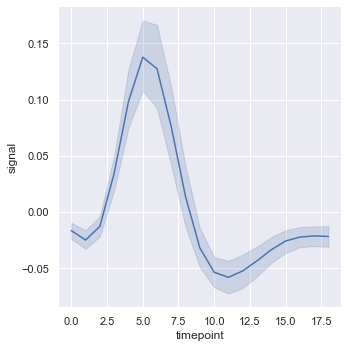

In [74]:
sns.relplot(x="timepoint", y="signal", kind="line", data=fmri);